In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib as mpl
from itertools import product
import scipy as sp
import scipy.interpolate

rc_cmufonts = {
    "font.family": "normal",
    "font.serif": [],
    "font.sans-serif": [],
    "font.monospace": [], 
    }
fs = 10
font = {'size'   : fs}

mpl.rc('font', **font)
mpl.rcParams.update(rc_cmufonts)
mpl.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
from IPython.kernel.zmq.pylab import backend_inline
cfg = backend_inline.InlineBackend.instance()# InlineBackendConfig.instance()
cfg.figure_format = 'svg' # 'png' to switch back

sns.set_context('paper', font_scale=1.5)
sns.set_style('white')
sns.mpl.rcParams['legend.frameon'] = 'False'
#sns.rcParams['legend.frameon'] = 'False'
palette = sns.color_palette() 
fig_format = 'pgf'

In [2]:
def opt_tau_fun(eps, res, dall, tau_all, gamma=2.):   
    tau_opt = {}
    for d in dall:
        for tau in tau_all:    
            err_h1 = res[(d, tau, eps, 'h1')]
            err_h1_qtt = res[(d, tau, eps, 'h1_qtt')]
            if np.abs(err_h1_qtt/err_h1) < gamma:
                tau_opt[d] = tau
                break
            if tau == tau_all[-1]:
                raise Exception('WTF?!')            
    return tau_opt

In [3]:
q = np.load('computations_diffusion.npz')
res = q["res"].item()
dall = q["dall"]
eps_all = q["eps_all"]
tau_all = q["tau_all"]

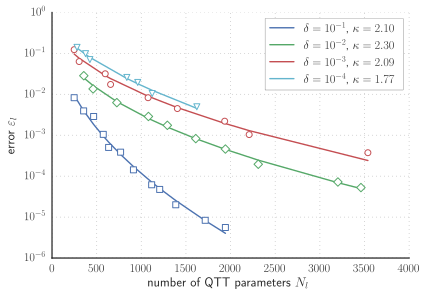

In [5]:
err_h1 = np.zeros((len(eps_all), len(dall)))
err_h1_qtt = np.zeros((len(eps_all), len(dall)))
err_l2 = np.zeros((len(eps_all), len(dall)))
mem = np.zeros((len(eps_all), len(dall)))

gamma = [2] * 4
for i_d, d in enumerate(dall):
    for i_eps, eps in enumerate([1e-1, 1e-2, 1e-3, 1e-4]):
        tau_opt = opt_tau_fun(eps, res, dall, tau_all, gamma=gamma[i_eps])
        err_h1[i_eps, i_d] = res[(d, tau_opt[d], eps, 'h1')]
        err_h1_qtt[i_eps, i_d] = res[(d, tau_opt[d], eps, 'h1_qtt')]
        err_l2[i_eps, i_d] = res[(d, tau_opt[d], eps, 'l2')]
        mem[i_eps, i_d] = res[(d, tau_opt[d], eps, 'memory')]

ax = plt.subplot(111)

x0 = mem[0, :]   
x1 = mem[1, 2:]  
x2 = mem[2, 3:]  
x3 = mem[3, 5:]  

y0 = err_h1_qtt[0, :]
y1 = err_h1_qtt[1, 2:]
y2 = err_h1_qtt[2, 3:]
y3 = err_h1_qtt[3, 5:]


fit0 = np.polyfit(np.log(x0), np.log(-np.log(y0)), 1)
fit1 = np.polyfit(np.log(x1), np.log(-np.log(y1)), 1)
fit2 = np.polyfit(np.log(x2), np.log(-np.log(y2)), 1)
fit3 = np.polyfit(np.log(x3), np.log(-np.log(y3)), 1)

fit_res0 = np.poly1d(fit0)
fit_res1 = np.poly1d(fit1)
fit_res2 = np.poly1d(fit2)
fit_res3 = np.poly1d(fit3)

ax.semilogy(x0, np.exp(-np.exp(fit_res0(np.log(x0)))), '-', color=palette[0],
             label='$\\delta=10^{-1}$, '+' $\\kappa={0:.2f}$'.format(1./fit0[0]))
ax.semilogy(x1, np.exp(-np.exp(fit_res1(np.log(x1)))), '-', color=palette[1],
             label='$\\delta=10^{-2}$, '+' $\\kappa={0:.2f}$'.format(1./fit1[0]))
ax.semilogy(x2, np.exp(-np.exp(fit_res2(np.log(x2)))), '-',  color=palette[2],
             label='$\\delta=10^{-3}$, '+' $\\kappa={0:.2f}$'.format(1./fit2[0]))
ax.semilogy(x3, np.exp(-np.exp(fit_res3(np.log(x3)))), '-', color=palette[5],
             label='$\\delta=10^{-4}$, '+' $\\kappa={0:.2f}$'.format(1./fit3[0]))

ax.semilogy(x0, y0, 's', markeredgewidth=1, markeredgecolor=palette[0], markerfacecolor='white', markersize=6)
ax.semilogy(x1, y1, 'D', markeredgewidth=1, markeredgecolor=palette[1], markerfacecolor='white', markersize=6)
ax.semilogy(x2, y2, 'o', markeredgewidth=1, markeredgecolor=palette[2], markerfacecolor='white', markersize=6)
ax.semilogy(x3, y3, 'cv', markeredgewidth=1, markeredgecolor=palette[5], markerfacecolor='white', markersize=6)

ax.grid(ls=":")
ax.set_xlabel('number of QTT parameters $N_l$')
ax.set_ylabel('error $\\varepsilon_l$') #, $H^1$ error')
ax.legend(loc='best', frameon=True)
#ax.axes('top').set_visiblee(False)
#ax.axis["top"].set_visible(False)

#ax.set_frame_on(False)
#plt.tick_params(which='major', length=4, direction='in')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

plt.savefig('h1_error_qtt.' + fig_format, bbox_inches='tight')

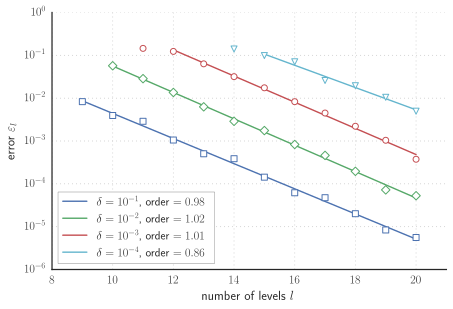

In [6]:
err_h1 = np.zeros((len(eps_all), len(dall)))
err_h1_qtt = np.zeros((len(eps_all), len(dall)))
arr_d = np.zeros(len(dall))
err_l2 = np.zeros((len(eps_all), len(dall)))
mem = np.zeros((len(eps_all), len(dall)))

gamma = [2] * 4
for i_d, d in enumerate(dall):
    arr_d[i_d] = d
    for i_eps, eps in enumerate([1e-1, 1e-2, 1e-3, 1e-4]):
        tau_opt = opt_tau_fun(eps, res, dall, tau_all, gamma=gamma[i_eps])
        err_h1[i_eps, i_d] = res[(d, tau_opt[d], eps, 'h1')]
        err_h1_qtt[i_eps, i_d] = res[(d, tau_opt[d], eps, 'h1_qtt')]
        err_l2[i_eps, i_d] = res[(d, tau_opt[d], eps, 'l2')]
        mem[i_eps, i_d] = res[(d, tau_opt[d], eps, 'memory')]


x0 = arr_d[:]   
x1 = arr_d[:]  
x2 = arr_d[:]  
x3 = arr_d[:]  

y0 = err_h1_qtt[0, :]
y1 = err_h1_qtt[1, :]
y2 = err_h1_qtt[2, :]
y3 = err_h1_qtt[3, :]

ax = plt.subplot(111)

fit0 = np.polyfit(x0, -np.log(y0), 1)
fit1 = np.polyfit(x1[1:], -np.log(y1[1:]), 1)
fit2 = np.polyfit(x2[3:], -np.log(y2[3:]), 1)
fit3 = np.polyfit(x3[6:], -np.log(y3[6:]), 1)

fit_res0 = np.poly1d(fit0)
fit_res1 = np.poly1d(fit1)
fit_res2 = np.poly1d(fit2)
fit_res3 = np.poly1d(fit3)

ax.semilogy(x0, (np.exp(-fit_res0(x0))), '-', color=palette[0],
             label='$\\delta=10^{-1}$, order'+' $={0:.2f}$'.format((fit0[0]/np.log(2))))
ax.semilogy(x1[1:], (np.exp(-fit_res1(x1[1:]))), '-', color=palette[1],
             label='$\\delta=10^{-2}$, order'+' $={0:.2f}$'.format((fit1[0]/np.log(2))))
ax.semilogy(x2[3:], (np.exp(-fit_res2(x2[3:]))), '-',  color=palette[2],
             label='$\\delta=10^{-3}$, order'+' $={0:.2f}$'.format((fit2[0]/np.log(2))))
ax.semilogy(x3[6:], (np.exp(-fit_res3(x3[6:]))), '-', color=palette[5],
             label='$\\delta=10^{-4}$, order'+' $={0:.2f}$'.format((fit3[0]/np.log(2))))

ax.semilogy(x0, y0, 's', markeredgewidth=1, markeredgecolor=palette[0], markerfacecolor='white', markersize=6)
ax.semilogy(x1[1:], y1[1:], 'D', markeredgewidth=1, markeredgecolor=palette[1], markerfacecolor='white', markersize=6)
ax.semilogy(x2[2:], y2[2:], 'o', markeredgewidth=1, markeredgecolor=palette[2], markerfacecolor='white', markersize=6)
ax.semilogy(x3[5:], y3[5:], 'cv', markeredgewidth=1, markeredgecolor=palette[5], markerfacecolor='white', markersize=6)
ax.legend(loc='best')

ax.grid(ls=":")
ax.set_xlabel('number of levels $l$')
ax.set_ylabel('error $\\varepsilon_l$')#$H^1$ error')
ax.legend(loc='best', frameon=True)
#ax.axes('top').set_visiblee(False)
#ax.axis["top"].set_visible(False)

#ax.set_frame_on(False)
#plt.tick_params(which='major', length=4, direction='in')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_xlim([8, 21])
plt.tight_layout()
plt.savefig('h1_error_l.' + fig_format, bbox_inches='tight')

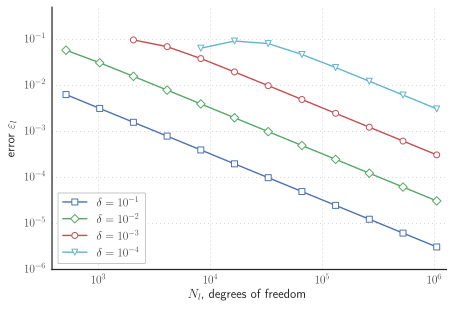

In [8]:
err_h1 = np.zeros((len(eps_all), len(dall)))
#err_h1_qtt = np.zeros((len(eps_all), len(dall)))
err_l2 = np.zeros((len(eps_all), len(dall)))
#mem = np.zeros((len(eps_all), len(dall)))

for i_d, d in enumerate(dall):
    for i_eps, eps in enumerate([1e-1, 1e-2, 1e-3, 1e-4]):
        err_h1[i_eps, i_d] = res[(d, tau_all[0], eps, 'h1')]
        err_h1_qtt[i_eps, i_d] = res[(d, tau_all[0], eps, 'h1_qtt')]
        err_l2[i_eps, i_d] = res[(d, tau_all[0], eps, 'l2')]
        
mem = 2**dall 

ax = plt.subplot(111)

x0 = mem[0:]
x1 = mem[0:]
x2 = mem[2:]
x3 = mem[4:]

y0 = err_h1[0, 0:]
y1 = err_h1[1, 0:]
y2 = err_h1[2, 2:]
y3 = err_h1[3, 4:]

ax.loglog(x0, y0, 's-', color=palette[0], markeredgewidth=1, markeredgecolor=palette[0], markerfacecolor='white', markersize=6, label='$\\delta=10^{-1}$')
ax.loglog(x1, y1, 'D-', color=palette[1], markeredgewidth=1, markeredgecolor=palette[1], markerfacecolor='white', markersize=6, label='$\\delta=10^{-2}$')
ax.loglog(x2, y2, 'o-', color=palette[2], markeredgewidth=1, markeredgecolor=palette[2], markerfacecolor='white', markersize=6, label='$\\delta=10^{-3}$')
ax.loglog(x3, y3, 'cv-', color=palette[5], markeredgewidth=1, markeredgecolor=palette[5], markerfacecolor='white', markersize=6, label='$\\delta=10^{-4}$')
#ax.loglog(mem, err_h1[1, :])
#ax.loglog(mem, err_h1[2, :])
#ax.loglog(mem, err_h1[3, :])


ax.grid(ls=":")
ax.set_xlabel('$N_l$, degrees of freedom')
ax.set_ylabel('error $\\varepsilon_l$')
ax.legend(loc='best', frameon=True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_xlim([3*1024/8, 1.*10**4 * 1024/8])
ax.set_ylim([10**(-6), 0.5])
plt.tight_layout()
plt.savefig('h1_error_full.' + fig_format, bbox_inches='tight')

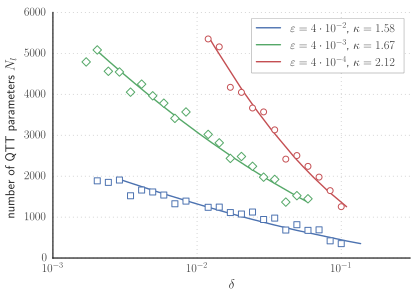

In [11]:
err_h1 = np.zeros((len(eps_all), len(dall)))
err_h1_qtt = np.zeros((len(eps_all), len(dall)))
err_l2 = np.zeros((len(eps_all), len(dall)))
mem = np.zeros((len(eps_all), len(dall)))


for i_d, d in enumerate(dall):
    for i_eps, eps in enumerate(eps_all):
        tau_opt = opt_tau_fun(eps, res, dall, tau_all, gamma=2.5)
        err_h1[i_eps, i_d] = res[(d, tau_opt[d], eps, 'h1')]
        err_h1_qtt[i_eps, i_d] = res[(d, tau_opt[d], eps, 'h1_qtt')]
        err_l2[i_eps, i_d] = res[(d, tau_opt[d], eps, 'l2')]
        mem[i_eps, i_d] = res[(d, tau_opt[d], eps, 'memory')]
 

err_h1_interp = []
for i_eps, eps in enumerate(eps_all):      
    ind = np.argsort(err_h1_qtt[i_eps, :])
    err_h1_interp.append(sp.interpolate.interp1d(err_h1_qtt[i_eps, ind], mem[i_eps, ind], kind='linear'))

mem_interp = []
for i_d, d in enumerate(dall):
    ind = np.argsort(mem[i_eps, :])
    mem_interp.append(sp.interpolate.interp1d(mem[:, i_d], eps_all))
    
errors_h1 = [4e-3, 4e-4, 4e-5]

mem_plot = np.zeros((len(errors_h1), len(eps_all)))
eps_plot = np.zeros((len(errors_h1), len(eps_all)))

for i_h1, h1 in enumerate(errors_h1):
    for i_eps, eps in enumerate(eps_all): 
        try:
            mem_plot[i_h1, i_eps] = err_h1_interp[i_eps](h1)
            eps_plot[i_h1, i_eps] = eps
        except:
            break

xlim = -30   
x0 = mem_plot[0, :xlim][mem_plot[0, :xlim]>0]
x1 = mem_plot[1, 3:][mem_plot[1, 3:]>0]
x2 = mem_plot[2, :][mem_plot[2, :]>0]

ind0 = np.argsort(x0)
ind1 = np.argsort(x1)
ind2 = np.argsort(x2)

y0 = eps_plot[0, :xlim][mem_plot[0, :xlim]>0]
y1 = eps_plot[1, 3:][mem_plot[1, 3:]>0]
y2 = eps_plot[2, :][mem_plot[2, :]>0]

x0 = x0[ind0]
x1 = x1[ind1]
x2 = x2[ind2]

y0 = y0[ind0]
y1 = y1[ind1]
y2 = y2[ind2]

y1 = np.delete(y1, 5)
x1 = np.delete(x1, 5)

y0 = np.delete(y0, 7)
x0 = np.delete(x0, 7)



fit0 = np.polyfit(np.log(x0), np.log(-np.log(y0)), 1)
fit1 = np.polyfit(np.log(x1), np.log(-np.log(y1)), 1)
fit2 = np.polyfit(np.log(x2), np.log(-np.log(y2)), 1)
#fit3 = np.polyfit(np.log(x3), np.log(-np.log(y3)), 1)

fit_res0 = np.poly1d(fit0)
fit_res1 = np.poly1d(fit1)
fit_res2 = np.poly1d(fit2)
#fit_res3 = np.poly1d(fit3)

ax = plt.subplot(111)

ax.semilogx(np.exp(-np.exp(fit_res0(np.log(x0)))), x0, 'b-', color=palette[0],
             label='$\\varepsilon=4\cdot 10^{-2}$, '+' $\\kappa={0:.2f}$'.format(1./fit0[0]))
ax.semilogx(np.exp(-np.exp(fit_res1(np.log(x1)))), x1, 'g-', color=palette[1],
             label='$\\varepsilon=4\cdot 10^{-3}$, '+' $\\kappa={0:.2f}$'.format(1./fit1[0]))
ax.semilogx(np.exp(-np.exp(fit_res2(np.log(x2)))), x2, 'r-', color=palette[2],
             label='$\\varepsilon=4\cdot 10^{-4}$, '+' $\\kappa={0:.2f}$'.format(1./fit2[0]))

ax.semilogx(y0, x0, 's', markeredgewidth=1, markeredgecolor=palette[0], markerfacecolor='white', markersize=6)
ax.semilogx(y1, x1, 'D', markeredgewidth=1, markeredgecolor=palette[1], markerfacecolor='white', markersize=6)
ax.semilogx(y2, x2, 'o', markeredgewidth=1, markeredgecolor=palette[2], markerfacecolor='white', markersize=6)

ax.grid(ls=":")
ax.set_ylabel('number of QTT parameters $N_l$')
ax.set_xlabel('$\\delta$')
ax.legend(loc='best', frameon=True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

ax.set_xlim([1e-3, 3e-1])

plt.savefig('delta_mem_qtt.' + fig_format, bbox_inches='tight')